# Noise2Void - 2D Example for time points between 390 and 399

Here, the volumetric images from camera CM02 have been flipped and translated. Then the two images are considered as two channels

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

Using TensorFlow backend.


# Training Data Preparation

## Load images from CM02

In [2]:
datagen = N2V_DataGenerator()

In [3]:
import glob
files=glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/*.tif")


In [4]:
for file in files:
    print(file)

/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/393.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/390.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/399.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/396.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/395.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/394.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/398.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/397.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/391.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/392.tif


In [5]:
files=glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
for file in files:
    print(file)

/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/393.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/390.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/399.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/396.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/395.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/394.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/398.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/397.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/391.tif
/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/392.tif


In [3]:
imgs_CM02 = datagen.load_imgs_from_directory(directory = "/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/", dims = "TYX")
print(len(imgs_CM02))
print(imgs_CM02[0].shape)


10
(70, 896, 576, 1)


## Load images from CM03

In [4]:
imgs_CM03 = datagen.load_imgs_from_directory(directory = "/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/", dims = "TYX")
print(len(imgs_CM03))
print(imgs_CM03[0].shape)

10
(70, 896, 576, 1)


## Combine imgs_CM02 and imgs_CM03 as two channels

In [5]:
imgs=[]
for i in range(len(imgs_CM02)):
    combined=np.empty([imgs_CM02[0].shape[0], imgs_CM02[0].shape[1], imgs_CM02[0].shape[2], 2])
    combined[..., 0]=imgs_CM02[i][..., 0]
    combined[..., 1]=imgs_CM03[i][..., 0]
    imgs.append(combined)
print(len(imgs))


10


## Visualize the images 

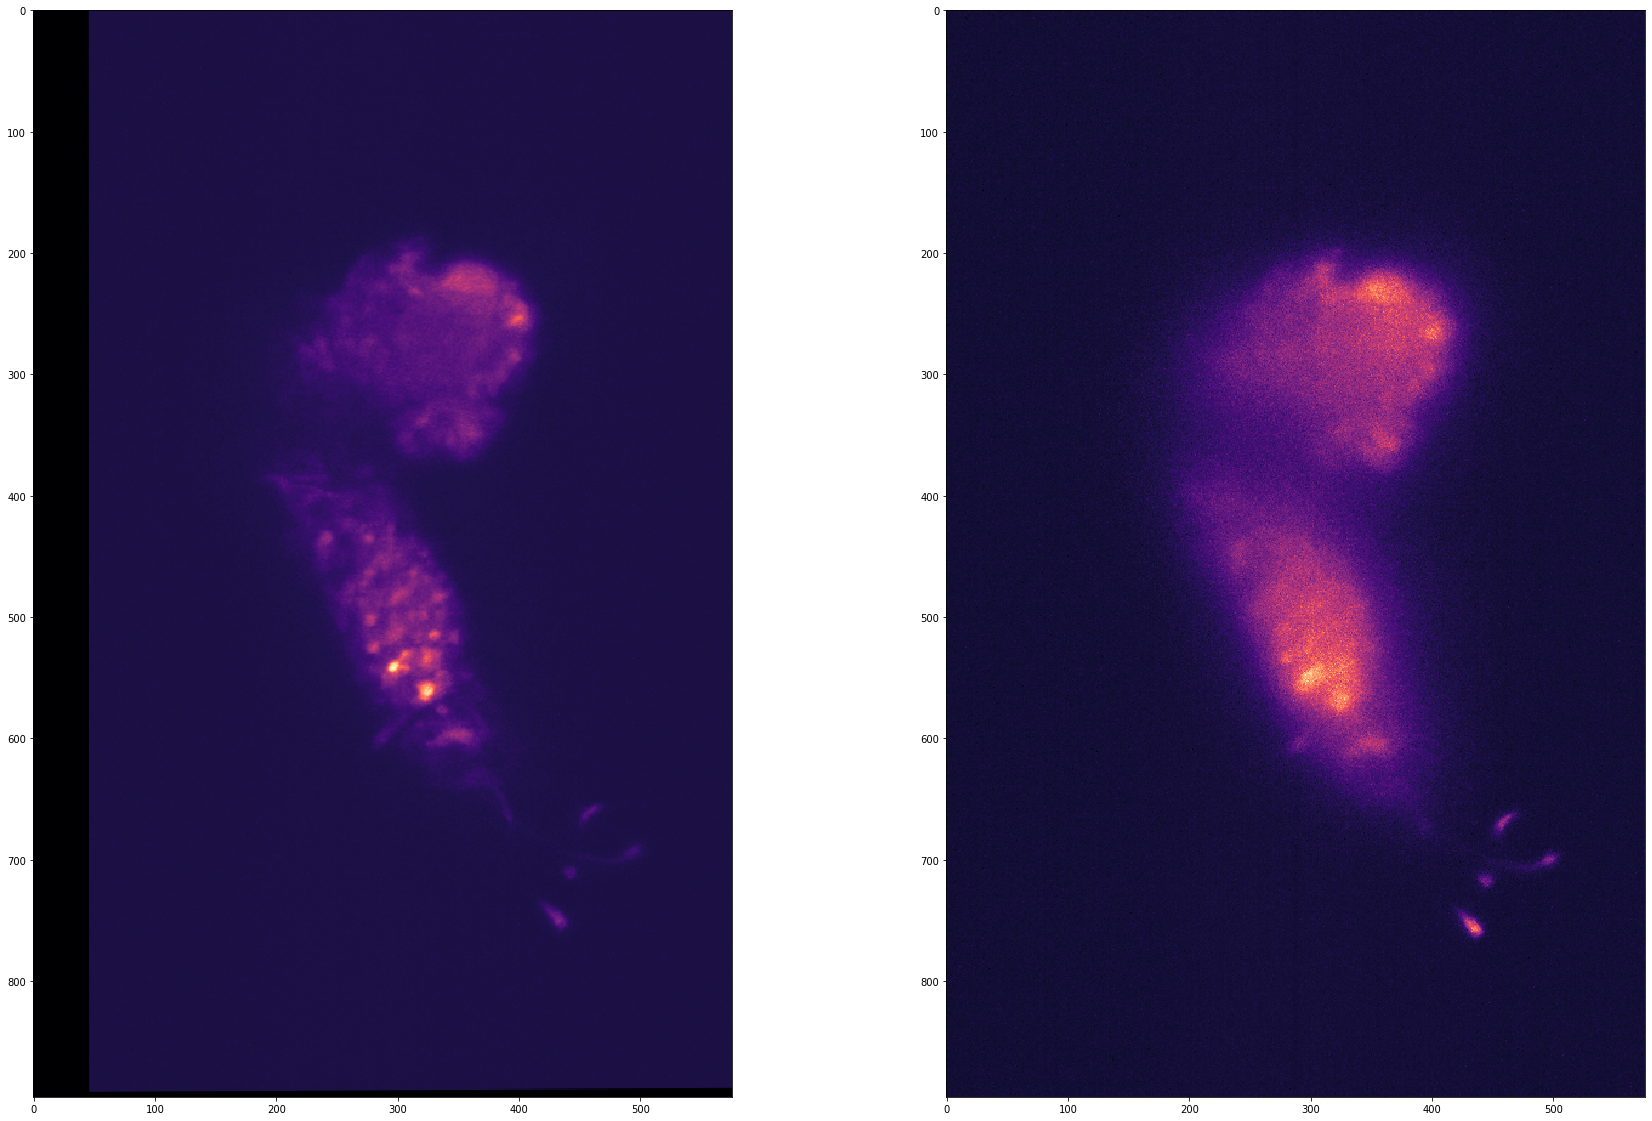

In [6]:
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgs[6][20,..., 0], cmap='magma')
plt.subplot(1,2,2)
plt.imshow(imgs[6][20,..., 1], cmap='magma')
plt.show()

## Delete the first 60 pixels from the x dimension

In [7]:
for i in range(len(imgs)):
    imgs[i]=imgs[i][..., 60:, :]
print(len(imgs))


10


In [8]:
print(imgs[0].shape)

(70, 896, 516, 2)


## Prepare train and validation data

In [9]:
# I assign the last image to validation set and the remaining to training
imgstrain=imgs[0:9]
imgsvalid=imgs[9:10]
print(len(imgstrain))
print(len(imgsvalid))


9
1


In [10]:
# We will use the first image to extract training patches and store them in 'X'
X = datagen.generate_patches_from_list(imgstrain, shape=(96, 96), augment=False)

# We will use the second image to extract validation patches.
X_val = datagen.generate_patches_from_list(imgsvalid, shape=(96, 96), augment=False)


print(X.shape)
print(X_val.shape)

# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches would also allow us to split them into a training and validation set 
# per image. This might be an interesting alternative to the split we performed above.

Generated patches: (3150, 96, 96, 2)
Generated patches: (3150, 96, 96, 2)
Generated patches: (3150, 96, 96, 2)
Generated patches: (3150, 96, 96, 2)
Generated patches: (3150, 96, 96, 2)
Generated patches: (3150, 96, 96, 2)
Generated patches: (3150, 96, 96, 2)
Generated patches: (3150, 96, 96, 2)
Generated patches: (3150, 96, 96, 2)
Generated patches: (3150, 96, 96, 2)
(28350, 96, 96, 2)
(3150, 96, 96, 2)


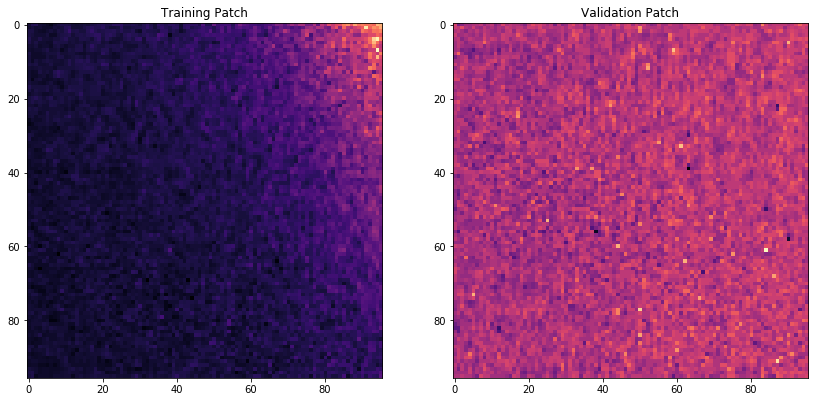

In [11]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[48, ...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[20,...,0], cmap='magma')
plt.title('Validation Patch');

# Configure

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 64 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 10 and <code>train_steps_per_epoch</code> to only 10. <br>For better results we suggest values of 100, and a few dozen, respectively.

In [12]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=20, train_epochs=25, train_loss='mse', 
                   batch_norm=True, train_batch_size=128, n2v_perc_pix=5, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'mean': '116.20630720057441',
 'std': '43.216880099743655',
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 2,
 'n_channel_out': 2,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 2),
 'train_loss': 'mse',
 'train_epochs': 25,
 'train_steps_per_epoch': 20,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5}

In [13]:
# a name used to identify the model
model_name = 'n2v_2D_kellerLab_T390-399_2Channels'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [14]:
# We are ready to start training now.
history = model.train(X, X_val)

Epoch 1/25
20/20 [==============================] - 266s 13s/step - loss: 0.5645 - n2v_mse: 0.5645 - n2v_abs: 0.3569 - val_loss: 2.0887 - val_n2v_mse: 2.0887 - val_n2v_abs: 0.4887
Epoch 2/25
20/20 [==============================] - 251s 13s/step - loss: 0.0762 - n2v_mse: 0.0762 - n2v_abs: 0.1482 - val_loss: 0.0699 - val_n2v_mse: 0.0699 - val_n2v_abs: 0.1653
Epoch 3/25
20/20 [==============================] - 248s 12s/step - loss: 0.0716 - n2v_mse: 0.0716 - n2v_abs: 0.1323 - val_loss: 0.1536 - val_n2v_mse: 0.1536 - val_n2v_abs: 0.2036
Epoch 4/25
20/20 [==============================] - 246s 12s/step - loss: 0.0726 - n2v_mse: 0.0726 - n2v_abs: 0.1385 - val_loss: 0.0569 - val_n2v_mse: 0.0569 - val_n2v_abs: 0.1489
Epoch 5/25
20/20 [==============================] - 244s 12s/step - loss: 0.0702 - n2v_mse: 0.0702 - n2v_abs: 0.1394 - val_loss: 0.0674 - val_n2v_mse: 0.0674 - val_n2v_abs: 0.1260
Epoch 6/25
20/20 [==============================] - 247s 12s/step - loss: 0.0681 - n2v_mse: 0.0681 -

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


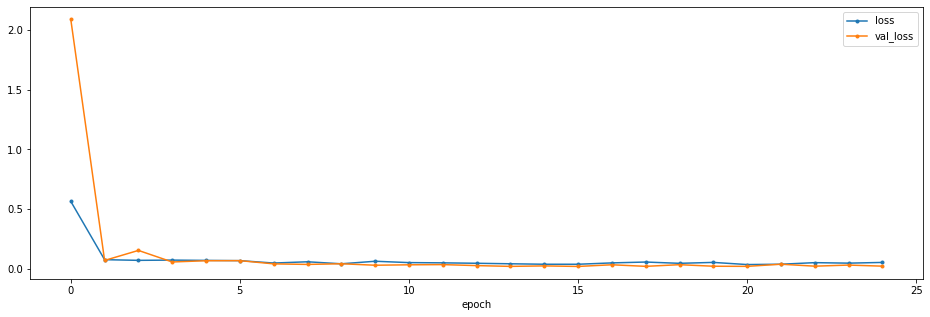

In [15]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model to be Used with CSBDeep Fiji Plugins and KNIME Workflows
See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [13]:
#model.export_TF()